# Стохастические бандиты

Сравним различные алгоритмы для стохастических бандитов.

In [3]:
from scipy.stats import bernoulli
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [4]:
#класс стохастических бандитов с бернулиевским распределением выигрышей

class BernoulliBandit:
  #принимает на вход список из K>=2 чисел из [0,1]
    def __init__(self, means):
        self.means = means
        self.sum_regret = 0
        new_means = np.array(means)
        self.best_arm = new_means.argmax()
    
  #возвращает число ручек
    def K(self):
        return len(self.means)

  #принимает параметр 0 <= a <= K-1 и возвращает реализацию случайной величины 
  #X c P[X=1] равной среднему значению выигрыша ручки a+1
    def pull(self, a):
        reward_a = bernoulli.rvs(p=self.means[a])
        self.sum_regret = self.sum_regret + bernoulli.rvs(p=self.means[self.best_arm]) - reward_a
        return reward_a

  #возвращает текущее значение регрета
    def regret(self):
        return self.sum_regret

Каждый алгоритм будет тестироваться:

1.   2 ручки ($\mu_1=0.5$, $\mu_2=0.6$), $T \in \{100, 200, \dots, 1000\}$,  проводится 1000 симуляций.
2.   10 ручек $(\mu_1 = 0.4, \dots, \mu_{10}=0.85)$, $T \in \{100, 200, \dots, 1000\}$,  проводится 1000 симуляций.
3.   Построим график среднего регрета как функцию от $T$.

1. Алгоритм "Следуй за лидером":

$\ \ \ \ \ \  \bullet$ Сыграть каждое действие 1 раз

$\ \ \ \ \ \  \bullet$ Играть действие (ручку) с максимальным на данный момент средним выигрышем

In [5]:
def FollowTheLeader(bandit, T):
    K = bandit.K()
    mean_rewards = np.zeros(K)
    num_pulling = np.ones(K)
    for t in range(T):
        if t < K:
            mean_rewards[t] = bandit.pull(t)
        if t >= K:
            best_arm = mean_rewards.argmax()
            current_reward = bandit.pull(best_arm)
            mean_rewards[best_arm] = (num_pulling[best_arm] * mean_rewards[best_arm] + current_reward) / (num_pulling[best_arm] + 1)
            num_pulling[best_arm] += 1

In [6]:
regret_FL_1 = []
for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    for _ in range(1000):
        bandit = BernoulliBandit([0.5, 0.6])
        FollowTheLeader(bandit, T)
        current_regret += bandit.regret() 
    regret_FL_1.append(current_regret / 1000)
    
regret_FL_2 = []
for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    for _ in range(1000):
        bandit = BernoulliBandit([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
        FollowTheLeader(bandit, T)
        current_regret += bandit.regret() 
    regret_FL_2.append(current_regret / 1000)

Text(0.5, 1.0, 'Follow the leader (10 arms)')

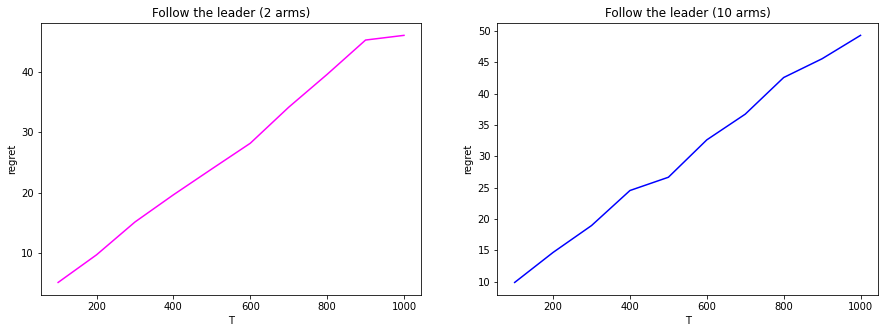

In [7]:
plt.rcParams['figure.figsize'] = [15, 5]    
plt.subplot(1, 2, 1)
plt.plot(range(100, 1001, 100), regret_FL_1, color='magenta')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('Follow the leader (2 arms)')

plt.subplot(1, 2, 2)
plt.plot(range(100, 1001, 100), regret_FL_2, color='blue')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('Follow the leader (10 arms)')

2. Алгоритм "Explore First":

$\ \ \ \ \ \  \bullet$ Сыграть каждое действие k раз

$\ \ \ \ \ \  \bullet$ Играть действие с максимальным средним выигрышем

In [8]:
def ExploreFirst(bandit, T, k):
  #k-число раз, сколько раз мы играем каждую ручку до exploitation фазы
    K = bandit.K()
    mean_rewards = np.zeros(K)
    num_pulling = np.zeros(K)
    #k = round((np.log(T) ** (1/3)) * T ** (2/3))
    for i in range(K):
        for _ in range(k):
            mean_rewards[i] += bandit.pull(i)
            num_pulling[i] += 1
    mean_rewards = np.array([j / k for j in mean_rewards])
    T -= k*K 
    for t in range(T):
        best_arm = mean_rewards.argmax()
        current_reward = bandit.pull(best_arm)
        mean_rewards[best_arm] = (num_pulling[best_arm] * mean_rewards[best_arm] + current_reward) / (num_pulling[best_arm] + 1)
        num_pulling[best_arm] += 1

In [9]:
regret_Exp_first_1 = []

for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    k = round((np.log(T) ** (1/3)) * T ** (2/3))
    for _ in range(1000):
        bandit = BernoulliBandit([0.5, 0.6])
        ExploreFirst(bandit, T, k)
        current_regret += bandit.regret() 
    regret_Exp_first_1.append(current_regret / 1000)
    
regret_Exp_first_2 = []
for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    k = round((np.log(T) ** (1/3)) * T ** (2/3) / 15)
    for _ in range(1000):
        bandit = BernoulliBandit([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
        ExploreFirst(bandit, T, k)
        current_regret += bandit.regret() 
    regret_Exp_first_2.append(current_regret / 1000)

Text(0.5, 1.0, 'Explore first (10 arms)')

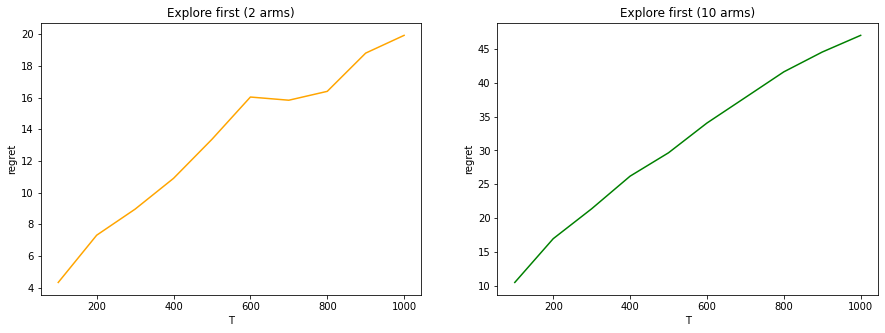

In [10]:
plt.rcParams['figure.figsize'] = [15, 5]    
plt.subplot(1, 2, 1)
plt.plot(range(100, 1001, 100), regret_Exp_first_1, color='orange')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('Explore first (2 arms)')

plt.subplot(1, 2, 2)
plt.plot(range(100, 1001, 100), regret_Exp_first_2, color='green')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('Explore first (10 arms)')

3. $\epsilon$-greedy алгоритм:

$\ \ \ \ \ \  \bullet$ Сэмплировать бернуллевскую случайную величину с вероятностью $\epsilon$

$\ \ \ \ \ \  \bullet$ Если успех, то выбирать случайное действие; иначе, играть действие с максимальным средним выигрышем

In [11]:
def EGreedy(bandit, T, e):
    K = bandit.K()
    mean_rewards = np.zeros(K)
    num_pulling = np.zeros(K)
    for t in range(T):
        coin_result = bernoulli.rvs(p=e)
        if coin_result == 1:
            arm = np.random.choice([j for j in range(K)])
            reward_arm = bandit.pull(arm)
            mean_rewards[arm] = (mean_rewards[arm] * num_pulling[arm] + reward_arm) / (num_pulling[arm] + 1)
            num_pulling[arm] += 1
        else:
            best_arm = mean_rewards.argmax()
            current_reward = bandit.pull(best_arm)
            mean_rewards[best_arm] = (num_pulling[best_arm] * mean_rewards[best_arm] + current_reward) / (num_pulling[best_arm] + 1)
            num_pulling[best_arm] += 1
            

In [12]:
regret_Egreedy_1 = []

for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    e = T ** (-1/3) * (2 * np.log(T)) ** (1/3)
    for _ in range(1000):
        bandit = BernoulliBandit([0.5, 0.6])
        EGreedy(bandit, T, e)
        current_regret += bandit.regret() 
    regret_Egreedy_1.append(current_regret / 1000)
    
regret_Egreedy_2 = []
for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    e = 0.5 * T ** (-1/3) * (10 * np.log(T)) ** (1/3)
    for _ in range(1000):
        bandit = BernoulliBandit([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
        EGreedy(bandit, T, e)
        current_regret += bandit.regret() 
    regret_Egreedy_2.append(current_regret / 1000)

Text(0.5, 1.0, 'E Greedy (10 arms)')

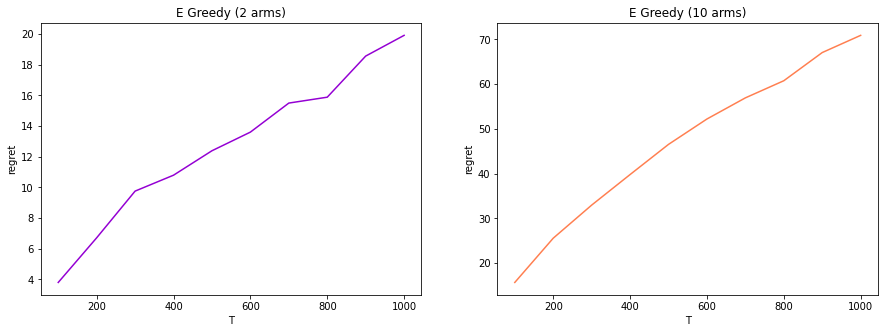

In [13]:
plt.rcParams['figure.figsize'] = [15, 5]    
plt.subplot(1, 2, 1)
plt.plot(range(100, 1001, 100), regret_Egreedy_1, color='darkviolet')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('E Greedy (2 arms)')

plt.subplot(1, 2, 2)
plt.plot(range(100, 1001, 100), regret_Egreedy_2, color='coral')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('E Greedy (10 arms)')

4. Алгоритм "Successive Elimination":

Введем некоторые необходимый обозначения:  $\ \overline \mu_a$ - эмперический средний выигрыш ручки $a$,  $\ r(a) = \sqrt{\dfrac{2 log T}{k}}$ - доверительный интервал ($T$ - количество раундов, $k$ - сколько раз мы до этого момента сыграли ручку $a$).

В цикле:

$\ \ \ \ \ \  \bullet$ Играть случайную активную ручку (изначально все ручки активные)

$\ \ \ \ \ \  \bullet$ Пересчитать эмперический средний выигрыш и доверительный интервал. Если есть две ручки $a_1, \ a_2$, такие что,нижнее значение одной ($\overline \mu_{a_1} - r(a_1)$) выше верхнего значения второй ($\overline \mu_{a_2} + r(a_2)$), то ручка $a_2$ перестает быть активной, то есть ее больше играть не будем.

In [14]:
def SuccessiveElimination(bandit, T):
    K = bandit.K()
    mean_rewards = np.zeros(K)
    num_pulling = np.ones(K)
    upper_bounds = np.zeros(K)
    bottom_bounds = np.zeros(K)
    active_arms = np.array(range(K))
    for i in range(K):
        mean_rewards[i] = bandit.pull(i)
        radius = 0.8 * (2 * np.log(T) / num_pulling[i]) ** 0.5
        upper_bounds[i] = mean_rewards[i] + radius
        bottom_bounds[i] = mean_rewards[i] - radius
    counter = T-K
    while counter > 0:
        max_bottom_bound = -10000
        for i in active_arms:
            if bottom_bounds[i] > max_bottom_bound:
                max_bottom_bound = bottom_bounds[i]
        new_active_arms = []
        for i in active_arms:
            if upper_bounds[i] > max_bottom_bound:
                new_active_arms.append(i)
        active_arms = np.array(new_active_arms)
        for i in active_arms:
            current_reward = bandit.pull(i)
            mean_rewards[i] = (num_pulling[i] * mean_rewards[i] + current_reward) / (num_pulling[i] + 1)
            num_pulling[i] += 1
            radius = 0.8 * (2 * np.log(T) / num_pulling[i]) ** 0.5
            upper_bounds[i] = mean_rewards[i] + radius
            bottom_bounds[i] = mean_rewards[i] - radius
        counter -= len(active_arms)

In [15]:
regret_SuccessElim_1 = []

for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    for _ in range(1000):
        bandit = BernoulliBandit([0.5, 0.6])
        SuccessiveElimination(bandit, T)
        current_regret += bandit.regret() 
    regret_SuccessElim_1.append(current_regret / 1000)
    
regret_SuccessElim_2 = []
for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    for _ in range(1000):
        bandit = BernoulliBandit([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
        SuccessiveElimination(bandit, T)
        current_regret += bandit.regret() 
    regret_SuccessElim_2.append(current_regret / 1000)

Text(0.5, 1.0, 'Successive Elimination (10 arms)')

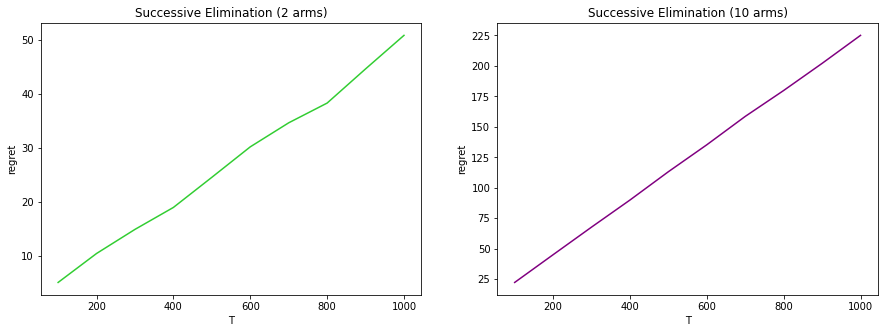

In [16]:
plt.rcParams['figure.figsize'] = [15, 5]    
plt.subplot(1, 2, 1)
plt.plot(range(100, 1001, 100), regret_SuccessElim_1, color='limegreen')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('Successive Elimination (2 arms)')

plt.subplot(1, 2, 2)
plt.plot(range(100, 1001, 100), regret_SuccessElim_2, color='purple')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('Successive Elimination (10 arms)')

5. Алгоритм UCB1:

$\ \ \ \ \ \  \bullet$ Сыграть каждую ручку по 1 разу

$\ \ \ \ \ \  \bullet$ Играть ручку с максимальным верхним значением $\overline \mu_a + r(a)$



In [17]:
def UCB(bandit, T):
    K = bandit.K()
    mean_rewards = np.zeros(K)
    num_pulling = np.ones(K)
    upper_bounds = np.zeros(K)
    for i in range(K):
        mean_rewards[i] = bandit.pull(i)
        upper_bounds[i] = mean_rewards[i] + (2 * np.log(T) / num_pulling[i]) ** 0.5
    for i in range(T-K):
        best_arm = upper_bounds.argmax()
        current_reward = bandit.pull(best_arm)
        mean_rewards[best_arm] = (num_pulling[best_arm] * mean_rewards[best_arm] + current_reward) / (num_pulling[best_arm] + 1)
        num_pulling[best_arm] += 1
        upper_bounds[best_arm] = mean_rewards[best_arm] + 0.8 * (2 * np.log(T) / num_pulling[best_arm]) ** 0.5

In [18]:
regret_UCB_1 = []

for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    for _ in range(1000):
        bandit = BernoulliBandit([0.5, 0.6])
        UCB(bandit, T)
        current_regret += bandit.regret() 
    regret_UCB_1.append(current_regret / 1000)
    
regret_UCB_2 = []
for T in tqdm(range(100, 1001, 100)):
    current_regret = 0
    for _ in range(1000):
        bandit = BernoulliBandit([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
        UCB(bandit, T)
        current_regret += bandit.regret() 
    regret_UCB_2.append(current_regret / 1000)

Text(0.5, 1.0, 'UCB (10 arms)')

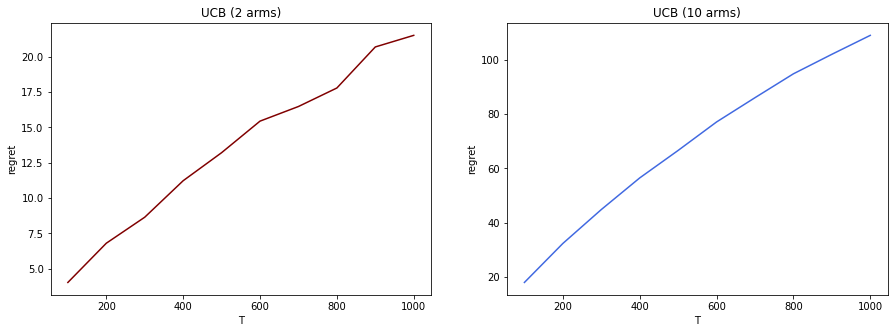

In [19]:
plt.rcParams['figure.figsize'] = [15, 5]    
plt.subplot(1, 2, 1)
plt.plot(range(100, 1001, 100), regret_UCB_1, color='maroon')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('UCB (2 arms)')

plt.subplot(1, 2, 2)
plt.plot(range(100, 1001, 100), regret_UCB_2, color='royalblue')
plt.xlabel('T')
plt.ylabel('regret')
plt.title('UCB (10 arms)')

Изобразим полученный результат работы всех алгоритмов на одном графике для 2 ручек, и для 10.

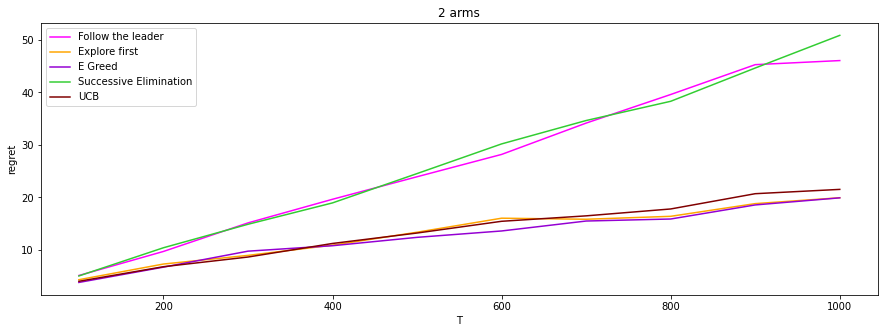

In [20]:
plt.plot(range(100, 1001, 100), regret_FL_1, color='magenta', label='Follow the leader')
plt.plot(range(100, 1001, 100), regret_Exp_first_1, color='orange', label='Explore first')
plt.plot(range(100, 1001, 100), regret_Egreedy_1, color='darkviolet', label='E Greed')
plt.plot(range(100, 1001, 100), regret_SuccessElim_1, color='limegreen', label='Successive Elimination')
plt.plot(range(100, 1001, 100), regret_UCB_1, color='maroon', label='UCB')


plt.xlabel('T')
plt.ylabel('regret')
plt.title('2 arms')
plt.legend(loc="upper left")
plt.show()

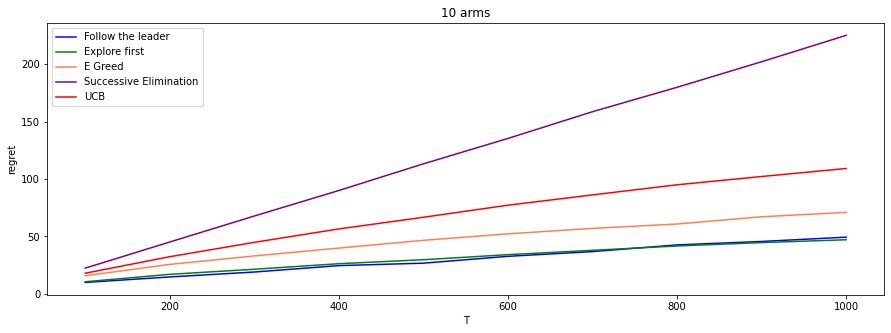

In [21]:
plt.plot(range(100, 1001, 100), regret_FL_2, color='blue', label='Follow the leader')
plt.plot(range(100, 1001, 100), regret_Exp_first_2, color='green', label='Explore first')
plt.plot(range(100, 1001, 100), regret_Egreedy_2, color='coral', label='E Greed')
plt.plot(range(100, 1001, 100), regret_SuccessElim_2, color='purple', label='Successive Elimination')
plt.plot(range(100, 1001, 100), regret_UCB_2, color='red', label='UCB')


plt.xlabel('T')
plt.ylabel('regret')
plt.title('10 arms')
plt.legend(loc="upper left")
plt.show()